# Experiments with torchfm, which has a range of models based on FM (Factorization Machines). 
None of these models are sequence-aware. 

In [1]:
%load_ext autoreload
%autoreload 2

In [281]:
import torchfm
from torchfm import layer as fm_layer, model as fm_model
from torchfm.model import fm, lr, nfm, wd
import torch.nn.functional as F
import pandas as pd
import pandas_options
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
tt = torch.tensor
import numpy as np
# import tqdm
import random
import matplotlib.pyplot as plt
import myfunclib as myfm
import d2l_torch as d2l

In [76]:
device = d2l.try_gpu()
print(device)

cuda:0


In [77]:
gdct = {
    'device': device,  # 'cpu'
    'embed_dim': 10,
    'nb_epochs': 100,
    'lr': 0.05,
    'wd': 1.e-5,
    'optim': 'adamW',
    'batch_size' : 4096
}

In [151]:
gdct['device'] = 'cpu'

In [393]:
batch_size = gdct['batch_size']
files = "attrib_2016.csv"
#data_dict = myfm.getData(files, batch_size=batch_size, nrows='all')
data_dict = myfm.getData(files, batch_size=batch_size, nrows=20000, shuffle=False)

In [394]:
data_dict['train_iter'].dataset.df.shape[0]

8581

In [395]:
train_iter = data_dict['train_iter']
field_dims = train_iter.dataset.field_dims

In [396]:
# cpu: device : -1
# gpu: device : 0, 1, ...
gdct

{'device': 'cpu',
 'embed_dim': 10,
 'nb_epochs': 100,
 'lr': 0.05,
 'wd': 1e-05,
 'optim': 'adamW',
 'batch_size': 4096}

In [397]:
embed_dim = gdct['embed_dim']
device = gdct['device']
field_dims = field_dims.to(device)
net = fm.FactorizationMachineModel(field_dims, embed_dim)
net.to(device)

FactorizationMachineModel(
  (embedding): FeaturesEmbedding(
    (embedding): Embedding(2298, 10)
  )
  (linear): FeaturesLinear(
    (fc): Embedding(2298, 1)
  )
  (fm): FactorizationMachine()
)

Create a method with dataset and DataLoader

In [398]:
optimizer, loss_func = myfm.setup_trainer(net, gdct)

optimiz_meth:  adamW
adamW


In [524]:
%%time
nb_epochs = gdct['nb_epochs']
losses = []
train_iter = data_dict['train_iter']

train_iter = DataLoader(data_dict['train_data'], batch_size=4096, shuffle=True)
print("nb training samples: ", len(train_iter.dataset), train_iter.dataset.df.shape)

nb_epochs = 20

for epoch in range(nb_epochs):
    total_loss = myfm.train_epoch(net, optimizer, train_iter, loss_func, device=gdct['device'], log_interval=10)
    losses.append(total_loss)
    if epoch % 1 == 0:
        print(f"Epoch {epoch}, avg total_loss (per training sample): ", total_loss)
        
#  ERROR: Check that all variables are on the same device. HOW TO DO THIS? try 'cuda'
#  8500 training samples
# time GPU, 5.6 sec for 4 epochs, batch 512
# time CPU, 5.8 sec for 4 epochs, batch 512
# time CPU, 7.1 sec for 4 epochs, batch 32
# time CPU, 5.7 sec for 4 epochs, batch 4096
# time CPU, 6.8 sec for 4 epochs, batch 32
# time GPU, 7.0 sec for 4 epochs, batch 32
# time GPU, 5.0 sec for 4 epochs, batch 4096

# ERROR? The loss per training sample should be independent of the batch size

nb training samples:  8581 (8581, 3)
Epoch 0, avg total_loss (per training sample):  0.020293093589568913
Epoch 1, avg total_loss (per training sample):  0.019987971925464042
Epoch 2, avg total_loss (per training sample):  0.019875695696250775
Epoch 3, avg total_loss (per training sample):  0.019683147381768323
Epoch 4, avg total_loss (per training sample):  0.02008892244013188
Epoch 5, avg total_loss (per training sample):  0.019766525319201336
Epoch 6, avg total_loss (per training sample):  0.019474614922539234
Epoch 7, avg total_loss (per training sample):  0.019562609675216024
Epoch 8, avg total_loss (per training sample):  0.01906830142716968
Epoch 9, avg total_loss (per training sample):  0.019390421995570416
Epoch 10, avg total_loss (per training sample):  0.018974290273044894
Epoch 11, avg total_loss (per training sample):  0.019295506471021195
Epoch 12, avg total_loss (per training sample):  0.0189703184684341
Epoch 13, avg total_loss (per training sample):  0.0188739058683460

In [404]:
list(net.parameters())[0].get_device()  # -1 for cpu

-1

In [405]:
a = list(net.parameters())[0].device
a

device(type='cpu')

In [406]:
%%time
test_iter = data_dict['train_iter']
print("length: ", len(test_iter.dataset))
test_iter = DataLoader(data_dict['train_data'], batch_size=4*1024, shuffle=True)
# fields: original dataframe as a torch array
# scores: scores from original dataframe
fields, scores = myfm.test_accuracy(net, test_iter, 'cpu')

length:  8581
fields_:  torch.Size([8582, 3]) torch.Size([8582])
<class 'torch.Tensor'>
CPU times: user 1.6 s, sys: 262 µs, total: 1.6 s
Wall time: 1.41 s


Select a sample of members, and compute scores for all destinations

In [407]:
data_iter = data_dict['train_iter']
data_iter.dataset.dct.keys()
dct = data_iter.dataset.dct
dct.keys()

dict_keys(['member_attr', 'dest_attr', 'field_dims', 'D_set', 'dest2idx', 'idx2dest', 'member2idx', 'idx2member'])

In [516]:
df = data_iter.dataset.df # dataframe
print(df.shape)
nb_members = 1000  # select random members
max_member = df['MEMBER_ID'].max()
max_dest = df['D'].max()
members = random.sample(range(0,max_member), 100)
destinations = list(range(0,max_dest+1))  # 0, 1, ..., max_dest
print("dest: ", destinations)
print("members[0]: ", members[0])
print("Size: ", df.groupby(['MEMBER_ID','D']).size().sum())
row = df.iloc[members[0],:]
print("row: ", row)

# create a dataframe with members*max_dest rows. 10000*100 = one million
# How to do this? 
#  1. create a specialized Dataset

#print('member_attr: ', dct['member_attr'])
#dct['idx2member'].keys()

(8581, 3)
dest:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
members[0]:  550
Size:  8581
row:  MEMBER_ID    1304
D              43
age             2
Name: 1111, dtype: int16


In [525]:
data = myfm.AccuracyDataset(data_iter.dataset, destinations)
len(data)

dest keys:  dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75])
destinations:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
nb members:  2218
dest:  76 76
len:  168568


168568

In [519]:
# shuffling is irrelevant
accuracy_loader = DataLoader(data, batch_size=4096, shuffle=False)
#accuracy_loader = DataLoader(data, batch_size=gdct['batch_size'], shuffle=False)

In [526]:
fields, predict = myfm.test_accuracy(net, train_iter, 'cpu')

print("fields: ", fields[0:5])
print("predict: ", predict[0:5])

# Strong decrease in loss. However, is this overfitting? 
# TODO: create a pair-wise approach. So define negative samples. 
# Could weigh the negative samples: flights not taken in the further back in time would have higher weight 
#  than more recent flights. Is that reasonable? 

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 3 but got size 1 for tensor number 1 in the list.

In [530]:
fields, predict = myfm.test_accuracy(net, accuracy_loader, 'cpu')

print("fields: ", fields[0:5])
print("predict: ", predict[0:50])
print(fields.shape, predict.shape)

# Strong decrease in loss. However, is this overfitting? 
# TODO: create a pair-wise approach. So define negative samples. 
# Could weigh the negative samples: flights not taken in the further back in time would have higher weight 
#  than more recent flights. Is that reasonable? 

len:  168568
10 torch.Size([4096])
20 torch.Size([4096])
30 torch.Size([4096])
40 torch.Size([4096])
fields_:  torch.Size([168569, 3]) torch.Size([168569])
<class 'torch.Tensor'>
fields:  tensor([[-5.5359e+31,  3.0903e-41, -5.9894e+31],
        [ 0.0000e+00,  0.0000e+00,  2.0000e+00],
        [ 0.0000e+00,  1.0000e+00,  2.0000e+00],
        [ 0.0000e+00,  2.0000e+00,  2.0000e+00],
        [ 0.0000e+00,  3.0000e+00,  2.0000e+00]])
predict:  tensor([-2.6637e-10,  1.3918e-06,  4.5932e-06,  1.4529e-05,  3.2717e-06,
         1.1951e-06,  2.6367e-03,  1.5958e-04,  9.5117e-07,  1.8141e-06,
         1.0429e-05,  1.8576e-06,  2.2482e-05,  2.4459e-06,  1.1418e-05,
         7.7358e-05,  1.2010e-06,  1.3315e-04,  1.2178e-06,  4.7219e-06,
         5.8062e-06,  1.8806e-04,  3.2983e-06,  8.5117e-06,  1.1026e-05,
         1.7008e-05,  9.8348e-05,  2.8895e-06,  9.9557e-05,  5.2313e-06,
         4.5578e-05,  8.2137e-04,  5.6976e-06,  1.5766e-05,  7.6919e-05,
         1.4510e-05,  1.8252e-06,  4.6926e-06

In [611]:
# fields: member_id, dest, age
# prediction: score
field_np = np.asarray(fields)
predict_np = np.asarray(predict)
#print(field_np.shape, predict_np.reshape(-1,1).shape)
joined = np.concatenate((field_np, predict_np.reshape(-1,1)), axis=1)
#print(joined[0:7,:])
df = pd.DataFrame(joined, columns=['MEMBER_ID','D','age','rank']) #, predict)
#print(df.head())

cols = list(df.columns)[0:-1]
for col in cols:
    df[col] = df[col].astype('int')
df = df.iloc[1:]

# data_iter: used for training
D_set = data_iter.dataset.dct['D_set']
print(len(D_set))
D_set.iloc[35], D_set.loc[35]

# Why is first row have numbers approx 1.e31? This is the input data. It has nothing to do with the evaluator. 
# for i in range(predict.shape[0]):

merged = df.merge(D_set, how='inner', on='MEMBER_ID')
print("merged shape (all scores): ", merged.shape, merged['MEMBER_ID'].nunique())  # 2218 unique members
merged = merged[merged['rank'] > 0.5]
print("merged shape (scores > 0.5): ", merged.shape, merged['MEMBER_ID'].nunique())  # 2170 unique members
print(merged.head(10))

2218
merged shape (all scores):  (168568, 5) 2218
merged shape (scores > 0.5):  (28204, 5) 2170
     MEMBER_ID   D  age  rank                            E
81           1   5    2 1.000  {32, 5, 40, 48, 23, 25, 26}
90           1  14    2 1.000  {32, 5, 40, 48, 23, 25, 26}
92           1  16    2 1.000  {32, 5, 40, 48, 23, 25, 26}
95           1  19    2 0.767  {32, 5, 40, 48, 23, 25, 26}
96           1  20    2 0.985  {32, 5, 40, 48, 23, 25, 26}
99           1  23    2 0.916  {32, 5, 40, 48, 23, 25, 26}
100          1  24    2 0.990  {32, 5, 40, 48, 23, 25, 26}
101          1  25    2 1.000  {32, 5, 40, 48, 23, 25, 26}
102          1  26    2 0.979  {32, 5, 40, 48, 23, 25, 26}
106          1  30    2 1.000  {32, 5, 40, 48, 23, 25, 26}


Determined the topN scores for all members in order. 

In [612]:
_df['MEMBER_ID'].max(

2217

In [644]:
df1 = merged.groupby('MEMBER_ID').agg({'rank':list})
# df1 = merged.groupby('MEMBER_ID')['rank'].transform('count') #agg({'rank':list})
# print(df1)
print(df1.shape)

def sort_func(col):
    col1 = np.asarray(col) #.argsort()
    col1 = np.asarray(col).argsort()
    #col1 = sorted(col1, reverse=True)
    return col1
    
rank = df1['rank'].apply(sort_func)
df2 = df1.copy()
df2['argrank'] = rank
print(df2.head())
print("df2.shape: ", df2.shape)
df2['D'] = [list(range(0,len(D_set)))] * len(df2)
print("len(list(range(0,len(D_set))))= ", len(list(range(0,len(D_set)))) )
print("D_set: ", D_set)
df2
# df3 = pd.concat([_df, df2], axis=1)
# _df.shape, df2.shape

(2170, 1)
                                                        rank  \
MEMBER_ID                                                      
1          [1.0, 0.9999781847000122, 0.9999500513076782, ...   
2          [0.9999890327453613, 0.9580170512199402, 0.999...   
3          [1.0, 0.9576034545898438, 0.9999902248382568, ...   
4          [1.0, 0.9999203681945801, 0.9627326130867004, ...   
5          [0.9999997615814209, 0.9996484518051147, 0.555...   

                                                     argrank  
MEMBER_ID                                                     
1          [20, 3, 5, 8, 13, 4, 6, 18, 12, 11, 10, 2, 1, ...  
2                                [4, 1, 7, 8, 6, 2, 5, 3, 0]  
3                         [3, 1, 6, 2, 10, 9, 8, 7, 4, 0, 5]  
4                 [2, 9, 12, 5, 8, 7, 1, 10, 3, 11, 0, 4, 6]  
5                             [2, 5, 1, 8, 9, 7, 6, 3, 0, 4]  
df2.shape:  (2170, 2)
len(list(range(0,len(D_set))))=  2218
D_set:                                  

,rank,argrank,D
MEMBER_ID,,,
1,"[1.0, 0.9999781847000122, 0.9999500513076782, ...","[20, 3, 5, 8, 13, 4, 6, 18, 12, 11, 10, 2, 1, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,"[0.9999890327453613, 0.9580170512199402, 0.999...","[4, 1, 7, 8, 6, 2, 5, 3, 0]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,"[1.0, 0.9576034545898438, 0.9999902248382568, ...","[3, 1, 6, 2, 10, 9, 8, 7, 4, 0, 5]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,"[1.0, 0.9999203681945801, 0.9627326130867004, ...","[2, 9, 12, 5, 8, 7, 1, 10, 3, 11, 0, 4, 6]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
5,"[0.9999997615814209, 0.9996484518051147, 0.555...","[2, 5, 1, 8, 9, 7, 6, 3, 0, 4]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
...,...,...,...
2212,"[0.9999005794525146, 0.9835137128829956, 0.999...","[4, 1, 8, 7, 5, 6, 2, 0, 3]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2213,"[1.0, 0.9562162756919861, 0.9762628674507141, ...","[4, 1, 2, 7, 11, 10, 3, 8, 0, 5, 6, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2214,"[0.9999998807907104, 0.6710203886032104, 0.999...","[4, 3, 1, 7, 2, 10, 11, 9, 8, 5, 0, 6]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [650]:
dst = list(data_iter.dataset.dct['idx2dest'].keys())
df
dst   # destinations 0 - 75 (76 values)
# I wish to apply argsort to them
df2['Dlist'] = [dst] * df2.shape[0]
# df2

# apply argrank to D Dlist

,rank,argrank,D,Dlist
MEMBER_ID,,,,
1,"[1.0, 0.9999781847000122, 0.9999500513076782, ...","[20, 3, 5, 8, 13, 4, 6, 18, 12, 11, 10, 2, 1, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,"[0.9999890327453613, 0.9580170512199402, 0.999...","[4, 1, 7, 8, 6, 2, 5, 3, 0]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,"[1.0, 0.9576034545898438, 0.9999902248382568, ...","[3, 1, 6, 2, 10, 9, 8, 7, 4, 0, 5]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,"[1.0, 0.9999203681945801, 0.9627326130867004, ...","[2, 9, 12, 5, 8, 7, 1, 10, 3, 11, 0, 4, 6]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
5,"[0.9999997615814209, 0.9996484518051147, 0.555...","[2, 5, 1, 8, 9, 7, 6, 3, 0, 4]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
...,...,...,...,...
2212,"[0.9999005794525146, 0.9835137128829956, 0.999...","[4, 1, 8, 7, 5, 6, 2, 0, 3]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2213,"[1.0, 0.9562162756919861, 0.9762628674507141, ...","[4, 1, 2, 7, 11, 10, 3, 8, 0, 5, 6, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2214,"[0.9999998807907104, 0.6710203886032104, 0.999...","[4, 3, 1, 7, 2, 10, 11, 9, 8, 5, 0, 6]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


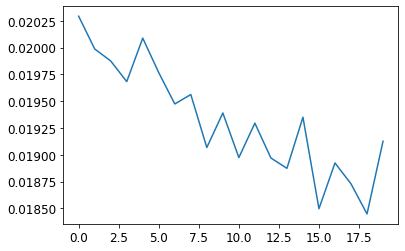

In [574]:
plt.plot(losses)
p

Compute scores of training data. 
* For each member_id, compute score for each destination. Rank destinations and compare against destinations actually travelled. 
* consider the 2016 data. For each user+user_attributes, cover a range of destinations. Each destination has its own destination attributes. 
Consider $n$ examples of destination attributes, compute a ranking of these $n$ items. There are 80 destinations and their attributes. Finally, 
there are attributes that are neither member destinations or desination attributes. 